### Axel Pribadi TP061236
Improvements in Deepfake Detection (DF-GANeXt)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import io
import cv2
from PIL import Image
'''
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
import keras
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
'''

'\nfrom tqdm import tqdm\nfrom PIL import Image\n\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score, classification_report, confusion_matrix\n\nimport tensorflow as tf\nimport keras\nfrom tensorflow.keras.applications import ConvNeXtTiny\nfrom tensorflow.keras.callbacks import Callback, ModelCheckpoint\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\nfrom tensorflow.keras.models import Sequential, Model, load_model\nfrom keras.layers import Dense, GlobalAveragePooling2D\n'

In [2]:
df_train = pd.read_csv("/Users/axel/Downloads/DF-GAN/train.csv")
df_valid = pd.read_csv("/Users/axel/Downloads/DF-GAN/valid.csv")
df_test = pd.read_csv("/Users/axel/Downloads/DF-GAN/test.csv")
print("Train:", df_train.shape, "Valid:", df_valid.shape, "Test:" ,df_test.shape)
df_train.head()

Train: (100000, 6) Valid: (20000, 6) Test: (20000, 6)


,Unnamed: 0,original_path,id,label,label_str,path
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     100000 non-null  int64 
 1   original_path  100000 non-null  object
 2   id             100000 non-null  object
 3   label          100000 non-null  int64 
 4   label_str      100000 non-null  object
 5   path           100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


In [4]:
print(df_valid["label"].unique())
print(df_valid["label_str"].unique())

[1 0]
['real' 'fake']


In [5]:
df_train["Type"] = "train"
df_valid["Type"] = "valid"
df_test["Type"] = "test"
df_test.head()

,Unnamed: 0,original_path,id,label,label_str,path,Type
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg,test
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg,test
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg,test
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg,test
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg,test


In [6]:
df = pd.concat([df_train, df_valid, df_test])
df = df.drop(columns = {"Unnamed: 0", "original_path"})
print(df.shape)
df.head()

(140000, 5)


,id,label,label_str,path,Type
0,31355,1,real,train/real/31355.jpg,train
1,02884,1,real,train/real/02884.jpg,train
2,33988,1,real,train/real/33988.jpg,train
3,53875,1,real,train/real/53875.jpg,train
4,24149,1,real,train/real/24149.jpg,train


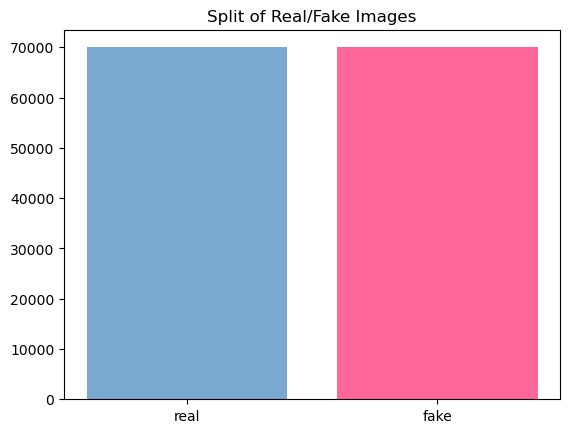

In [7]:
plt.bar(df["label_str"].unique(), df["label"].value_counts(), 
        color = ["#79A9D1", "#ff6699"])

plt.title("Split of Real/Fake Images")

plt.show()

In [8]:
df_grouped = df.groupby(['label_str', 'Type']).size().unstack()
order = ['train', 'valid', 'test']
df_grouped = df_grouped[order]
df_grouped = df_grouped.T
df_grouped.columns = ['real', 'fake']
df_grouped = df_grouped.T

In [9]:
df_grouped

Type,train,valid,test
real,50000,10000,10000
fake,50000,10000,10000


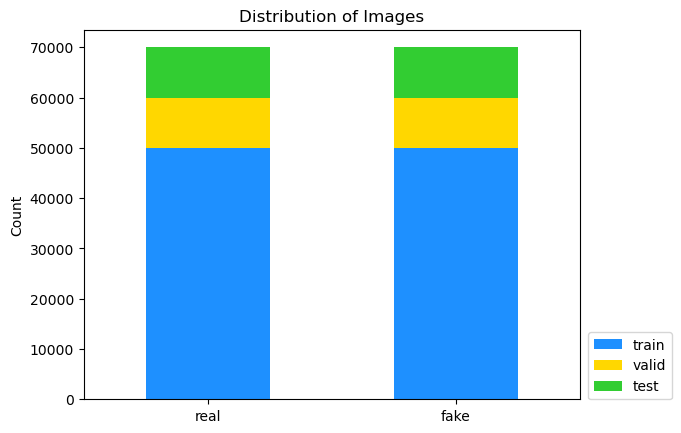

In [10]:
# plot a stacked bar chart to show the distribution of images by train/valid/test sets 
df_grouped.plot(kind='bar', stacked=True, 
                color = ['#1E90FF', '#FFD700', '#32CD32'])

plt.xticks(rotation=0)
plt.legend(bbox_to_anchor = (1.2, 0.2))

plt.xlabel("")
plt.ylabel("Count")
plt.title("Distribution of Images")
plt.show()

In [11]:
img_type = []

for i in range(len(df)):
    type_ = df["path"].iloc[i][-4:]
    
    if type_ not in img_type:
        img_type.append(type_)
    

In [12]:
img_type

['.jpg']

In [13]:
images = np.random.choice(df["path"],100, replace = False)

In [14]:
path = '/Users/axel/Downloads/DF-GAN/real_vs_fake/real-vs-fake/'
img_sizes = []
for i in images:
    img = cv2.imread(path + i)
    img_sizes.append(img.shape)

print(set(img_sizes))

{(256, 256, 3)}


In [15]:
real_show = list(df[df["label"] == 1].sample(16)["path"])
fake_show = list(df[df["label"] == 0].sample(16)["path"])

In [16]:
def plot_img(path, set_, list_):
    k = 0
    fig, ax = plt.subplots(4,4, figsize=(8,8))
    fig.suptitle(set_ + 'Faces')
    for j in range(4):
        for i in range(4):
            img = Image.open(path + list_[k])
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_.title() + ' Faces', size = 24)
    return plt

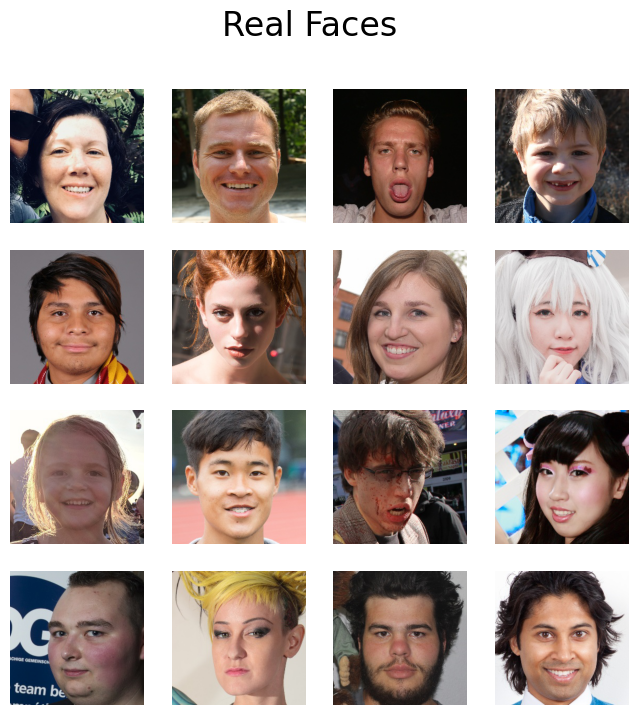

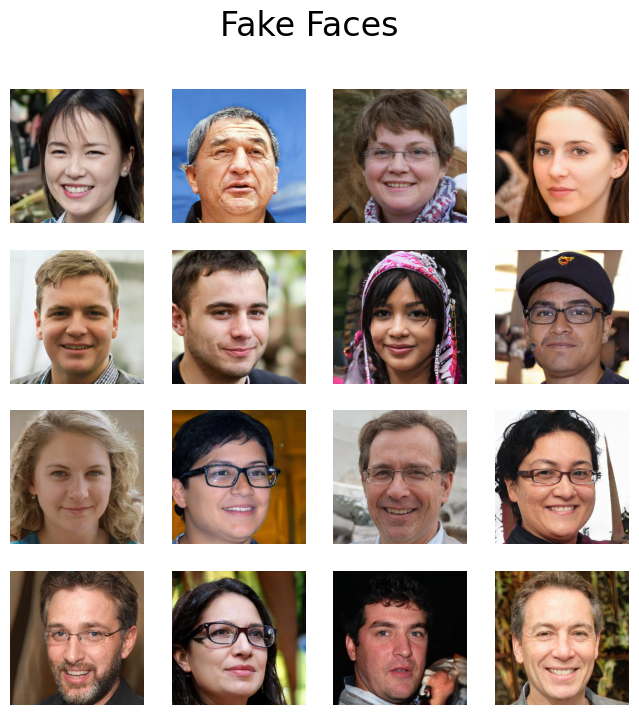

In [17]:
plot_img(path, 'real', real_show).show()
plot_img(path, 'fake', fake_show).show()